In [107]:
#Importing packages, setting style for charts

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd as pt
import warnings

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [108]:
# Reading in the dataframes

movie_info    = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t') # mi
tmdb          = pd.read_csv('zippedData/tmdb.movies.csv.gz') #tmdb
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz') # mb
movie_gross   = pd.read_csv("zippedData/bom.movie_gross.csv.gz") # mg
reviews       = pd.read_csv("zippedData/rt.reviews.tsv.gz", error_bad_lines=False, sep='\t', encoding= 'unicode_escape')

# 1. Cleaning Data

In [109]:
# Adding a column that concantenates the title and release date of the movie for dataframe merging with movie_budgets dataframe
tmdb_title = tmdb['original_title']
tmdb_date = tmdb['release_date']
tmdb['title_and_year'] = tmdb_title + ' ' + tmdb_date.apply(lambda x: x[:4])

# Removing duplicates from tmdb
tmdb = tmdb.drop_duplicates(subset='id', keep='first')
tmdb = tmdb.drop_duplicates(subset='title_and_year', keep='first')

In [110]:
# Adding a matching column in movie_budgets to prepare for merge with tmdb dataframe
mb_title = movie_budgets['movie']
mb_date = movie_budgets['release_date']
movie_budgets['title_and_year'] = mb_title + ' ' + mb_date.apply(lambda x: x[-4:])

In [111]:
# Creating numeric columns to represent revenue and budget
movie_budgets['revenue'] = movie_budgets['worldwide_gross'].replace('[\$,]','', regex=True).astype(float)
movie_budgets['budget'] = movie_budgets['production_budget'].replace('[\$,]','', regex=True).astype(float)

# Removing duplicates
movie_budgets = movie_budgets.drop_duplicates(subset='title_and_year', keep='first')

In [112]:
# Merging the tmdb and movie_budgets dataframe
tmdb_n_budgets = pd.merge(movie_budgets, tmdb, how='inner', on='title_and_year')

"""
Filtering to rows that have greater than $0 in revenue. 
Research showed that many of these movies were released directly to streaming services, not theatres
"""
tmdb_n_budgets = tmdb_n_budgets.loc[tmdb_n_budgets['revenue'] != 0]
tmdb_n_budgets.head()

,id_x,release_date_x,movie,production_budget,domestic_gross,worldwide_gross,title_and_year,revenue,budget,Unnamed: 0,genre_ids,id_y,original_language,original_title,popularity,release_date_y,title,vote_average,vote_count
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",Avatar 2009,2.776345e+09,425000000.0,6,"[28, 12, 14, 878]",19995,en,Avatar,26.526,2009-12-18,Avatar,7.4,18676
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",Pirates of the Caribbean: On Stranger Tides 2011,1.045664e+09,410600000.0,2470,"[12, 28, 14]",1865,en,Pirates of the Caribbean: On Stranger Tides,30.579,2011-05-20,Pirates of the Caribbean: On Stranger Tides,6.4,8571
2,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",Avengers: Age of Ultron 2015,1.403014e+09,330600000.0,14169,"[28, 12, 878]",99861,en,Avengers: Age of Ultron,44.383,2015-05-01,Avengers: Age of Ultron,7.3,13457
3,7,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200",Avengers: Infinity War 2018,2.048134e+09,300000000.0,23811,"[12, 28, 14]",299536,en,Avengers: Infinity War,80.773,2018-04-27,Avengers: Infinity War,8.3,13948
4,9,"Nov 17, 2017",Justice League,"$300,000,000","$229,024,295","$655,945,209",Justice League 2017,6.559452e+08,300000000.0,20623,"[28, 12, 14, 878]",141052,en,Justice League,34.953,2017-11-17,Justice League,6.2,7510


# 2. Linear Regression

### In this section we conducted linear regression tests on the movie's budget, vote average, and revenue to see how they are related

In [113]:
budget = tmdb_n_budgets['budget']
vote_average = tmdb_n_budgets['vote_average']

model = sm.OLS(vote_average, sm.add_constant(budget))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           vote_average   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     23.58
Date:                Tue, 20 Jun 2023   Prob (F-statistic):           1.32e-06
Time:                        23:58:17   Log-Likelihood:                -1854.5
No. Observations:                1504   AIC:                             3713.
Df Residuals:                    1502   BIC:                             3724.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2627      0.028    226.929      0.000       6.209       6.317
budget      1.869e-09   3.85e-10      4.856      0.000    1.11e-09    2.62e-09
==============================================================================
Omnibus:                       32.028   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.793
Skew:                          -0.290   Prob(JB):                     6.21e-09
Kurtosis:                       3.516   Cond. No.                     9.24e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.24e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

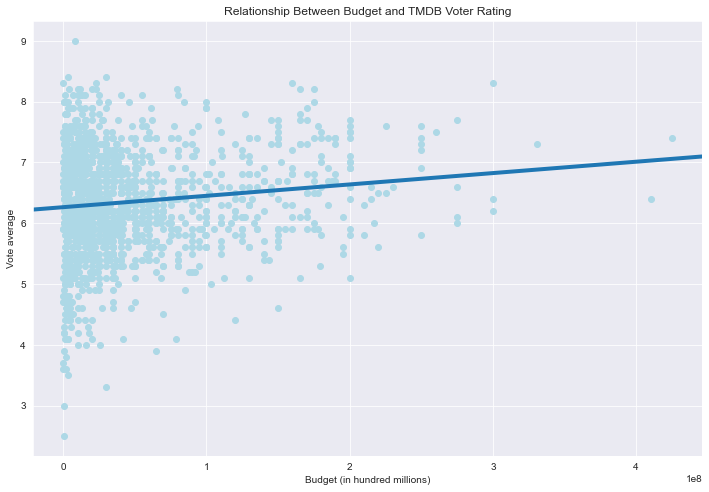

In [114]:
# Plotting the vote_average vs. budget
fig, ax=plt.subplots(figsize=(12,8))
ax.scatter(budget, vote_average, color='lightblue')
ax.set_xlabel('Budget (in hundred millions)')
ax.set_ylabel('Vote average')
ax.set_title('Relationship Between Budget and TMDB Voter Rating')
sm.graphics.abline_plot(model_results=results, ax=ax, linewidth=4);

In [115]:
budget = tmdb_n_budgets['budget']
revenue = tmdb_n_budgets['revenue']
model=sm.OLS(revenue, sm.add_constant(budget))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     2533.
Date:                Tue, 20 Jun 2023   Prob (F-statistic):               0.00
Time:                        23:58:17   Log-Likelihood:                -30421.
No. Observations:                1504   AIC:                         6.085e+04
Df Residuals:                    1502   BIC:                         6.086e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.404e+06    4.9e+06     -1.921      0.055    -1.9e+07       2e+05
budget         3.4360      0.068     50.332      0.000       3.302       3.570
==============================================================================
Omnibus:                      808.821   Durbin-Watson:                   1.364
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13310.254
Skew:                           2.128   Prob(JB):                         0.00
Kurtosis:                      16.938   Cond. No.                     9.24e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.24e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

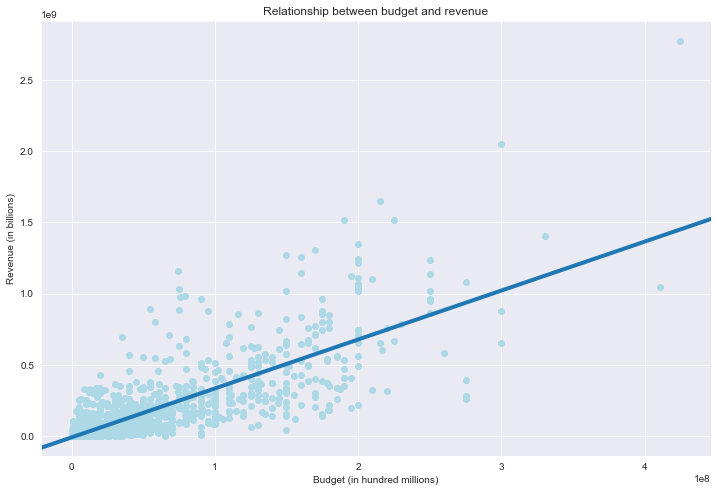

In [116]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(budget, revenue, color='lightblue')
ax.set_xlabel('Budget (in hundred millions)')
ax.set_ylabel('Revenue (in billions)')
ax.set_title('Relationship between budget and revenue')
sm.graphics.abline_plot(model_results=results, ax=ax, linewidth=4);

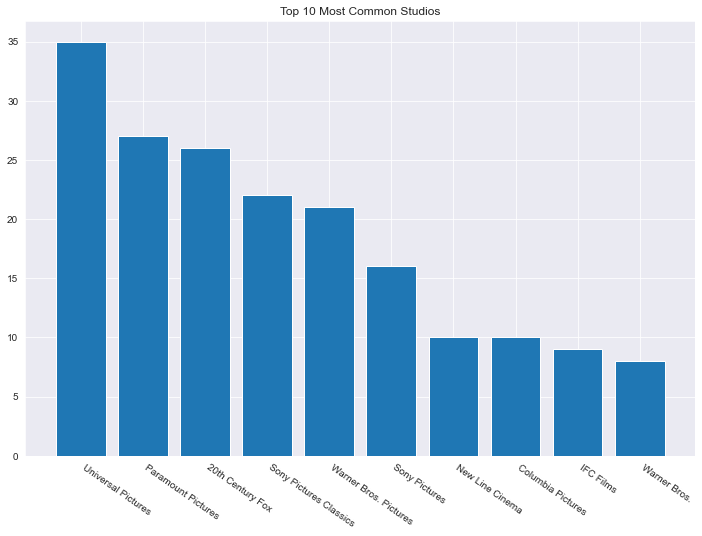

In [117]:
top_10_studio = movie_info['studio'].value_counts()[:10].index
top_10_studio_counts = movie_info['studio'].value_counts()[:10].values

fig, ax = plt.subplots(figsize=(12,8))
ax.bar(top_10_studio, top_10_studio_counts)
ax.set_xticklabels(top_10_studio, rotation=-35, ha='left')
ax.set_title('Top 10 Most Common Studios');

In [118]:
tmdb_n_budgets['year'] = tmdb_n_budgets['release_date_y'].apply(lambda x: x[:4]).astype(int)
revenue_by_year = tmdb_n_budgets.groupby('year')['revenue'].mean()

In [119]:
X = revenue_by_year.index
y = revenue_by_year.values
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.8618
Date:                Tue, 20 Jun 2023   Prob (F-statistic):              0.359
Time:                        23:58:17   Log-Likelihood:                -790.97
No. Observations:                  38   AIC:                             1586.
Df Residuals:                      36   BIC:                             1589.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.987e+09   5.59e+09     -0.891      0.379   -1.63e+10    6.36e+09
x1            2.6e+06    2.8e+06      0.928      0.359   -3.08e+06    8.28e+06
==============================================================================
Omnibus:                       49.578   Durbin-Watson:                   2.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              224.245
Skew:                           3.119   Prob(JB):                     2.02e-49
Kurtosis:                      13.134   Cond. No.                     2.53e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.53e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [120]:
# Reset index due to dropping rows
tmdb_n_budgets.reset_index(inplace=True)

# Remove unnecessary columns
tmdb_n_budgets.drop(['index', 'id_x', 'id_y', 'Unnamed: 0'], axis=1, inplace=True)

tmdb_n_budgets.tail()

,release_date_x,movie,production_budget,domestic_gross,worldwide_gross,title_and_year,revenue,budget,genre_ids,original_language,original_title,popularity,release_date_y,title,vote_average,vote_count,year
1499,"Nov 12, 2010",Tiny Furniture,"$50,000","$391,674","$424,149",Tiny Furniture 2010,424149.0,50000.0,"[10749, 35, 18]",en,Tiny Furniture,6.695,2010-11-12,Tiny Furniture,5.9,82,2010
1500,"Jul 31, 2015",Counting,"$50,000","$8,374","$8,374",Counting 2015,8374.0,50000.0,[99],en,Counting,0.600,2015-07-31,Counting,8.3,3,2015
1501,"Feb 11, 2011",Raymond Did It,"$40,000","$3,632","$3,632",Raymond Did It 2011,3632.0,40000.0,[27],en,Raymond Did It,1.675,2011-03-27,Raymond Did It,3.7,8,2011
1502,"Mar 18, 2016",Krisha,"$30,000","$144,822","$144,822",Krisha 2016,144822.0,30000.0,[18],en,Krisha,5.288,2016-03-18,Krisha,6.8,86,2016
1503,"Sep 1, 2015",Exeter,"$25,000",$0,"$489,792",Exeter 2015,489792.0,25000.0,"[53, 27]",en,Exeter,5.934,2015-03-26,Exeter,4.7,121,2015


In [122]:
tmdb_genres={
'Action':        28,
'Adventure':       12,
'Animation':       16,
'Comedy':          35,
'Crime':           80,
'Documentary':     99,
'Drama':           18,
'Family':          10751,
'Fantasy':         14,
'History':         36,
'Horror':          27,
'Music':           10402,
'Mystery':        9648,
'Romance':         10749,
'Science Fiction': 878,
'TV Movie':        10770,
'Thriller':        53,
'War':             10752,
'Western':         37}

# Reverses the key and values of the tmdb_genres dictionary
tmdb_genres_swap = {y:x for x,y in tmdb_genres.items()}

# Converts the ids in genre_ids to a list from a string and replaces the id with its corresponding genre
tmdb_n_budgets['genre_ids'] = tmdb_n_budgets['genre_ids'].apply(lambda x: [tmdb_genres_swap.get(int(id), 'X') for id in x.strip('[]').split(',') if len(id) != 0])

# Resetting index and dropping duplicate columns again after removing rows
tmdb_n_budgets.reset_index(inplace=True)
tmdb_n_budgets.drop(['index'], axis=1, inplace=True)

AttributeError: 'list' object has no attribute 'strip'

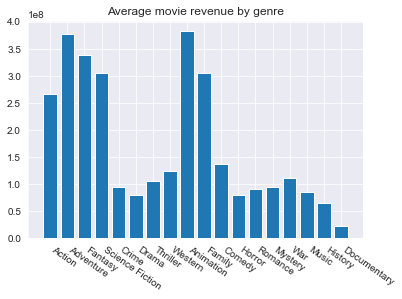

In [133]:
genre_n_revenue = {}

"""
Loops through each movie and appends a list of revenues associated with each of the movies' genres
The dictionary will result in keys representing the genres and the values being a list of revenues
"""
for row in tmdb_n_budgets.index:
    g_ids = tmdb_n_budgets.iloc[row]['genre_ids']
    rev = tmdb_n_budgets.iloc[row]['revenue']
    for g in g_ids:
        if g in genre_n_revenue.keys():
            genre_n_revenue[g] = np.append(genre_n_revenue[g], rev)
        else:
            genre_n_revenue[g] = np.array([rev])

genre_and_revenue_average = {}

# Adds a key (genre) and value (average revenue) to the genre_and_revenue_average dictionary
for g in genre_n_revenue.keys():
    genre_and_revenue_average[g] = genre_n_revenue[g].mean()

fig, ax = plt.subplots()
ax.bar(genre_and_revenue_average.keys(), genre_and_revenue_average.values())
ax.set_title('Average movie revenue by genre')
ax.set_xticklabels(genre_and_revenue_average.keys(), rotation=-35, ha='left');

In [134]:
# Checking to see if genre has a statistically significant impact on revenue
stats.f_oneway(*genre_n_revenue.values())

F_onewayResult(statistic=44.84863384460695, pvalue=3.4563026597519652e-137)

Since the p-value is extremely small and less than 0.05, we conclude that genre does have a statistically significant impact on revenue.

We will now replace the genre ids with the actual genre names, and then analyze the ratio of revenue to budget by genre.

In [137]:
tmdb_n_budgets['revenue_to_budget'] = tmdb_n_budgets['revenue'] / tmdb_n_budgets['budget']

In [139]:
genre_rois = {}

for row in tmdb_n_budgets.index:
    g_ids = tmdb_n_budgets.iloc[row]['genre_ids']
    rtb = tmdb_n_budgets.iloc[row]['revenue_to_budget']
    for g in g_ids:
        if g in genre_rois.keys():
            genre_rois[g] = np.append(genre_rois[g], rtb)
        else:
            genre_rois[g] = np.array([rtb])

genre_rois_average = {}
for g in genre_rois.keys():
    genre_rois_average[g] = genre_rois[g].mean()

genre_rois_average

{'Action': 2.8445543476074677,
 'Adventure': 3.256334414162225,
 'Fantasy': 3.2480465355054586,
 'Science Fiction': 3.607353759756162,
 'Crime': 2.702837128108868,
 'Drama': 3.2386691909339707,
 'Thriller': 5.371078105187498,
 'Western': 1.6573053339634713,
 'Animation': 3.88630585673147,
 'Family': 3.5099992705588554,
 'Comedy': 3.5129645718451865,
 'Horror': 11.009585157813289,
 'Romance': 3.8883719658041738,
 'Mystery': 5.374170979124497,
 'War': 2.356601874654575,
 'Music': 3.2331544464826396,
 'History': 2.516939570721482,
 'Documentary': 3.2652166397885694}

#### Does genre have a statistically significant impact on return on investment?
Before we make recommendations on which genres to invest in, we must first determine whether genre is statistically significant in our data when it comes to predicting return on investment.

In [140]:
stats.f_oneway(*genre_rois.values())

F_onewayResult(statistic=5.648207136299678, pvalue=7.349557648426371e-13)

Since our p-value is less than 0.05, we conclude that there is a statistically significant difference in return on investment by genre. Therefore we will conduct further analysis to see which genres are the best investments.

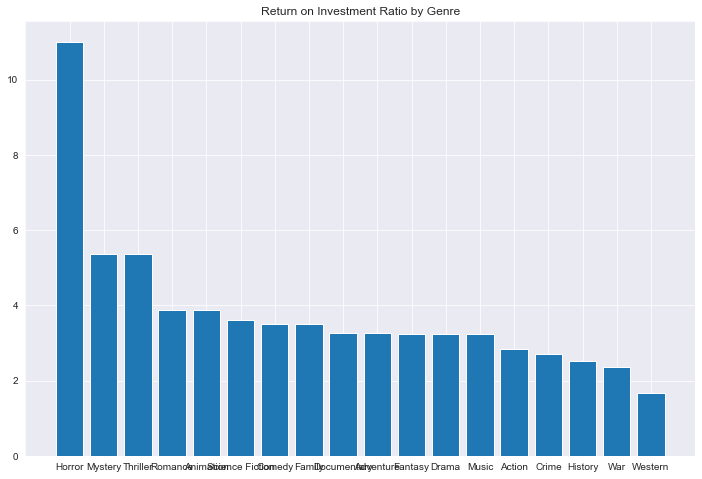

In [141]:
genre_ids = list(genre_rois_average.keys())
rois = list(genre_rois_average.values())
genres_and_rois = pd.DataFrame(data=rois, index=genre_ids, columns={'Return on Investment'})
genres_and_rois.sort_values(by='Return on Investment', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(12,8))
ax.bar(genres_and_rois.index, genres_and_rois['Return on Investment'])
ax.set_title('Return on Investment Ratio by Genre');

We can see that genre 27 has the highest return on investment, followed by genres 9648 and 53.

## What about for current movies only? Are the results different?
Our investor asked us to look specifically at how movies are currently doing in the box office, so we will filter the results further to movies released after 2017.

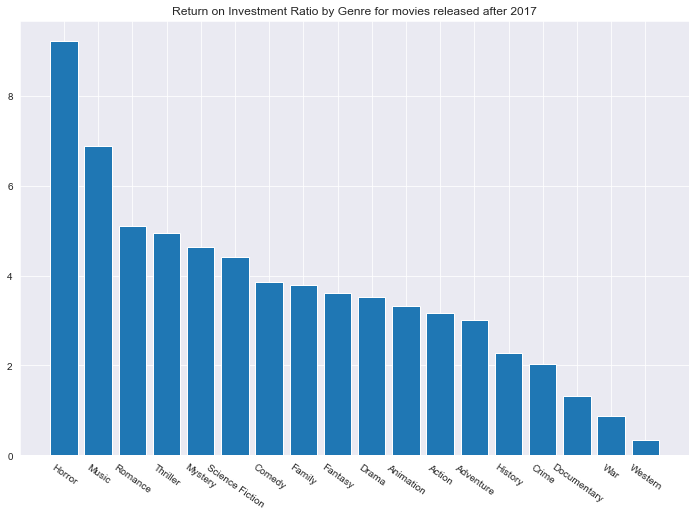

In [142]:
#repeating the same steps as above, but for new movies only

new_movies=tmdb_n_budgets.loc[tmdb_n_budgets['year']>2017]
new_movies.reset_index(inplace=True)

new_genre_rois={}
for row in new_movies.index:
    g_ids=new_movies.iloc[row]['genre_ids']
    rtb=new_movies.iloc[row]['revenue_to_budget']
    for g in g_ids:
        if g in new_genre_rois.keys():
            new_genre_rois[g]=np.append(new_genre_rois[g], rtb)
        else:
            new_genre_rois[g]=np.array([rtb])

new_genre_rois_average={}
for g in new_genre_rois.keys():
    new_genre_rois_average[g]=new_genre_rois[g].mean()

assert(stats.f_oneway(*new_genre_rois.values())[1]<0.05)

new_movies_genres_and_rois=pd.DataFrame(index=new_genre_rois_average.keys(), data=new_genre_rois_average.values(), columns={'Return on Investment'})
new_movies_genres_and_rois.sort_values(by='Return on Investment', ascending=False, inplace=True)

fig, ax=plt.subplots(figsize=(12,8))
ax.bar(new_movies_genres_and_rois.index, new_movies_genres_and_rois['Return on Investment'])
ax.set_title('Return on Investment Ratio by Genre for movies released after 2017')
ax.set_xticklabels(new_movies_genres_and_rois.index, rotation=-35, ha='center');


Horror still has the highest return on investment, although the gap is not as wide when filtered to new movies only. Music and romance have also done well recently in the box office.

The top genres we recommend are Horror, Music, Romance, Thriller, and Mystery.